# Summary and Introduction

This assignment requires the use of Reinforcement Learning to build an agent which controls a TurtleBot3 to reach a goal in the fewest steps possible in a simulated indoor environment. Two robot navigation models must be created a linear model, and a non-linear model. 

The main components are the environment robot.py and robot_environment.py, and the the agent eg Sarsa or DQN (see Assessment2.ipynb). The environment provides the reward and state, and the agent learns the policy to pick the best set of actions.

```plaintext
RL/
├── env/
│   ├── grid.py
│   ├── gridln.py
│   ├── gridnn.py
│   ├── mountainln.py
│   ├── robot.py           ← Gazebo interface and Environment
│   └── robot_old.py
├── rl/
│   ├── dp.py              ← Dynamic programming
│   ├── rl.py              ← Core RL logic
│   ├── rlln.py            ← Linear approximation model
│   ├── rlnn.py            ← Non-linear model 
│   └── rlselect.py        ← "Runs" code for running experimental trials comparing
│
├── Assessment2.ipynb      ← This code part of submission
├── robot_environment.py   ← vRobEnv includes state representation and reward structure

├── remote_control.py      ← Allows driving the robot around using wasd and the step function in the robenv
├── robenv_monitor.py      ← allows you to monitor the "reward" and "s_" of the environment as it is moving around, uses "ignoreReset = True" to be passive
├── feature_monitor.py     ← used for testing hand crafted features

```

The map isn't simple, there are maze like features. My intuition was that it should hug walls to the goal, but unfortuneately I didn't get a useful policy. 

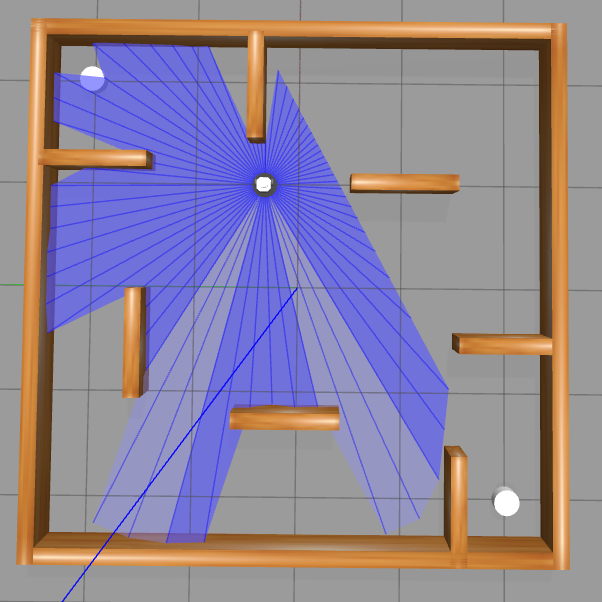


# ROS Environment

## State Messages
Gazebo runs the simulation of the Robot in it's virtual world. In ROS all communication is message based, so /odom and /scan data are broadbast and "nodes" can subscribe to the messages. This lets you listen to the messages and view them without influencing the system (ie the robot does not know or care who is observing it).

RVIZ and Topic Inspector are two inbuilt tools that let you view published messages


![Description](RVIZ.png)

![Description](TopicInspector.png)

## Command messages
To sent commands to the robot you publish messages to a topic, and the robot listens and processes them.
There are standard programs which are part of ROS for sending twist messages to the robot from the keyboard and joystick (ros2 run turtlebot3_teleop teleop_keyboard)




## Computer setup

I originally tried to setup Jazzy on 24.04 but this only works with Gazebo Sim (Ignition) and that needs different model types to the old Gazebo Classic. I then used 22.04 Humble. This worked very well.

![Description](RosCompatibility.png)



## Environment File

-`RobEnv`: A ROS2 node that connects a TurtleBot robot with a Gazebo simulation. It manages robot control, sensor readings, and interactions within the environment.
-`vRobEnv(RobEnv):`: Specialisations for vectorised state representation

-`odom`: Processes odometry data, updating the robot's position (`x, y`) and orientation (`θ`).  
-`scan`: Reads laser scan data, replacing infinite values with the maximum sensor range.  
-`yaw`: Converts quaternion orientation into a yaw angle in radians.  

-`θgoal`: Computes the angular distance between the robot and a goal.  
-`distgoal`: Calculates the Euclidean distance to the closest goal.  
-`atgoal`: Checks if the robot has reached a goal.  
-`atwall`: Detects potential collisions based on laser scan data.  

-`reward`: Assigns a reward based on the robot's state and action. It encourages movement towards goals and penalises collisions or undesired actions. If the robot collides with a wall, it automatically resets the environment.  

-`s_`: Converts the robot’s real-world position and orientation into a discrete state representation, mapping it to a grid system.  

-`spin_n`: Ensures the node updates by calling `ros.spin_once` multiple times.  
-`control`: Publishes movement commands.  
-`step`: Executes a specified action (`forward, turn left, turn right`), computes the next state, and returns a reward.  
-`stop`: Halts all movement.  

-`reset`: Restarts the simulation, ensuring a fresh environment for new episodes.  


## Note on step wise architecture

The setup is designed in a "step" wise fashion, so that the robot moves forward and then stops, this is so that it matches the techniques we have learnt in the module. I'd be very interested in knowing if we can use RL techniques for continuous control where we can leave the turtlebot moving and not have to stop it after each "step".

# Imports / Constants

In [2]:
%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np

from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 

True
NVIDIA GeForce RTX 3080 Ti


In [ ]:
#Need to nuke write protection for these files
#sudo chmod 777 /opt/ros/humble/share/turtlebot3_gazebo/worlds/turtlebot3_assessment2/burger.model
#sudo chmod 777 /opt/ros/humble/share/turtlebot3_gazebo/models/turtlebot3_burger/model.sdf

accelerate_sim(speed=100)
set_nscans_LiDAR(nscans=64)

#Note restart gazebo after changing these

### Common / Helper Functions

In [5]:
def print_robot_odom(env: RobEnv):
    #note: env.x and env.y are rounded to 1dp
    print (f"Odom. Pos:[{env.x},{env.y}] Yaw:{env.θ}")

# Connect to ROS / Configure Environment

1) Launch simulation environment
2) init ros (connect to ROS DDS eventing)
3) create environment

In [3]:

# Start Gazebo
# Assessment world:
# ros2 launch turtlebot3_gazebo turtlebot3_assessment2.launch.py

# Other worlds
# ros2 launch turtlebot3_gazebo turtlebot3_simple.launch.py 
# ros2 launch turtlebot3_gazebo empty_world.launch.py
# ros2 launch turtlebot3_gazebo turtlebot3_world.launch.py
# ros2 launch turtlebot3_gazebo turtlebot3_house.launch.py
# rviz2 

if not ros.ok():
    ros.init()

nscans = get_nscans_LiDAR()
print(f"Num laser scans in sensor:'{nscans}'")
# set_nscans_LiDAR(nscans=64)

# accelerate_sim(speed=10)
# Note running on my machine (AMD Ryzen 9 7950X, 64GB RAM, 3080TI) I got a stable Real Time Factor of 1.00 in the simulation.
# I had problems if I set the real time target to more than this, and from reading up this is a knowm limitation in the old Gazebo environment
# the new Gazebo Sim properly abstracts time so there is a simulation time independent from wall clock time. This version doesn't play nicely unless it's 1:1
# See Simulation Speed in ROS/Gazebo   




Num laser scans in sensor:'64'


In [7]:

test_connection = False
if test_connection:
    θspeed = pi/3.5
    speed = 10.0
    n = 6

    env = RobEnv(speed=speed, θspeed=θspeed, n=n, verbose=True)
    env.reset()
    print_robot_odom(env)

    for _ in range(10): env.step()

    print_robot_odom(env)

    env.reset()

# Calibrate Speed and θspeed

The following functions were used to sweep through different settings for speed and θspeed until the robot number of degrees and actual movememt got unreliable.

Speeds:   0%|          | 0/6 [00:00<?, ?it/s]





























Speeds:  17%|█▋        | 1/6 [00:01<00:07,  1.55s/it]





























Speeds:  33%|███▎      | 2/6 [00:03<00:06,  1.56s/it]





























Speeds:  50%|█████     | 3/6 [00:04<00:04,  1.53s/it]





























Speeds:  67%|██████▋   | 4/6 [00:06<00:03,  1.54s/it]





























Speeds:  83%|████████▎ | 5/6 [00:07<00:01,  1.55s/it]





























Speeds: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


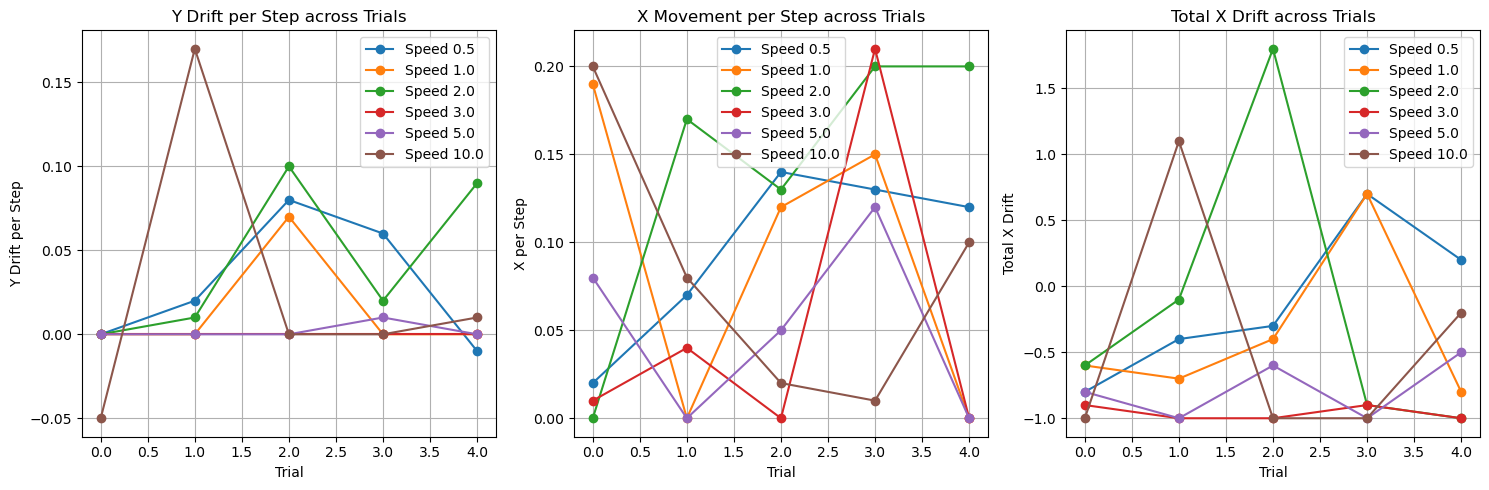

{'speed': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  3.0,
  3.0,
  3.0,
  3.0,
  3.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  10.0,
  10.0,
  10.0,
  10.0,
  10.0],
 'trial': [0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4,
  0,
  1,
  2,
  3,
  4],
 'yDriftPerStep': [0.0,
  0.02,
  0.08,
  0.06,
  -0.01,
  -0.0,
  0.0,
  0.06999999999999999,
  0.0,
  -0.0,
  0.0,
  0.01,
  0.1,
  0.02,
  0.09,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -0.0,
  -0.0,
  0.01,
  0.0,
  -0.05,
  0.16999999999999998,
  0.0,
  0.0,
  0.01],
 'xPerStep': [0.02,
  0.06999999999999999,
  0.13999999999999999,
  0.13,
  0.12,
  0.19,
  0.0,
  0.12,
  0.15,
  0.0,
  0.0,
  0.16999999999999998,
  0.13,
  0.2,
  0.2,
  0.01,
  0.04,
  -0.0,
  0.21000000000000002,
  0.0,
  0.08,
  -0.0,
  0.05,
  0.12,
  0.0,
  0.2,
  0.08,
  0.02,
  0.01,
  0.1],
 'xDrift': [-0.8,
  -0.4,
  -0.3,
 

In [8]:
def forward_test(env, speed=2.0):
    env.speed = speed
    env.reset()
    
    steps = 10
    for _ in tqdm(range(steps), desc=f"Moving at speed {speed}", leave=False):
        env.step(FORWARDS)

    yDriftPerStep = env.y / steps
    xPerStep = env.x / steps
    #print(f"Speed {speed}: y drift = {yDriftPerStep:.4f}, x per step: {xPerStep:.4f}")

    BACKWARDS = -1 #not used in simulation, just used to test repeatability
    for _ in tqdm(range(steps), desc=f"Moving at speed {speed}", leave=False):
        env.step(BACKWARDS)

    xDrift = env.x

    return yDriftPerStep, xPerStep, xDrift

num_trials = 5
speeds = [0.5, 1.0, 2.0, 3.0,5.0, 10.0]
log = {"speed": [], "trial": [], "yDriftPerStep": [], "xPerStep": [], "xDrift": []}

for speed in tqdm(speeds, desc="Speeds"):
    for trial in tqdm(range(num_trials), desc=f"Trials at speed {speed}", leave=False):
        y_drift, x_step, xDrift = forward_test(env, speed=speed)
        log["speed"].append(speed)
        log["trial"].append(trial)
        log["yDriftPerStep"].append(y_drift)
        log["xPerStep"].append(x_step)
        log["xDrift"].append(xDrift)


plt.figure(figsize=(15, 5))

# Plot y drift per step
plt.subplot(1, 3, 1)
for speed in speeds:
    y_drift_vals = [log["yDriftPerStep"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), y_drift_vals, marker='o', label=f"Speed {speed}")

plt.title('Y Drift per Step across Trials')
plt.xlabel('Trial')
plt.ylabel('Y Drift per Step')
plt.legend()
plt.grid(True)

# Plot x movement per step
plt.subplot(1, 3, 2)
for speed in speeds:
    x_step_vals = [log["xPerStep"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), x_step_vals, marker='o', label=f"Speed {speed}")
plt.title('X Movement per Step across Trials')
plt.xlabel('Trial')
plt.ylabel('X per Step')
plt.legend()
plt.grid(True)

# Plot total x drift
plt.subplot(1, 3, 3)
for speed in speeds:
    x_drift_vals = [log["xDrift"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), x_drift_vals, marker='o', label=f"Speed {speed}")
plt.title('Total X Drift across Trials')
plt.xlabel('Trial')
plt.ylabel('Total X Drift')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

display(log)

Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=0.57, step=30, elapsed (s)=0.4]  
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=6.30, step=28, elapsed (s)=0.9]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=13.18, step=24, elapsed (s)=1.2] 
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=10.31, step=30, elapsed (s)=1.7]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=24.06, step=17, elapsed (s)=2.0] 
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=3.44, step=34, elapsed (s)=2.5]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=0.00, step=26, elapsed (s)=2.9]  
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=26.36, step=29, elapsed (s)=3.4]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=0.57, step=21, elapsed (s)=3.7]  
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=4.01, step=33, elapsed (s)=4.3]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=5.73, step=26, elapsed (s)=4.6

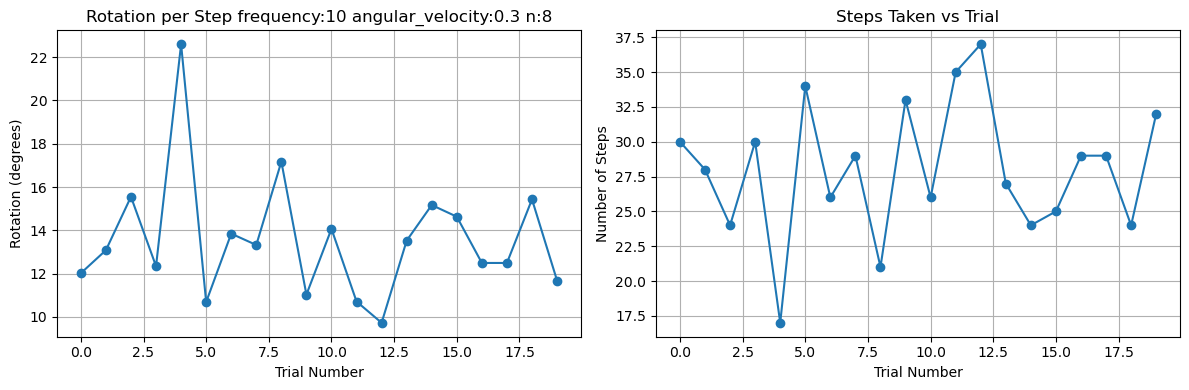

Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=30.94, step=12, elapsed (s)=0.4] 
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=22.35, step=10, elapsed (s)=0.7]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=48.13, step=10, elapsed (s)=1.0]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=9.17, step=13, elapsed (s)=1.4]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=41.25, step=15, elapsed (s)=1.8] 
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=23.49, step=12, elapsed (s)=2.2]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=6.88, step=11, elapsed (s)=2.5]  
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=18.33, step=13, elapsed (s)=2.9]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=18.91, step=10, elapsed (s)=3.2]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=36.10, step=12, elapsed (s)=3.6]
Calibrating Rotation: 0step [00:00, ?step/s, rotation (°)=28.65, step=15, elapsed (s)=4.

KeyboardInterrupt: 

In [9]:
def measure_rotation(robot : RobEnv, nTrials=20, frequency=10, angular_velocity=0.3, nSteps=8):
    
    robot.freq = frequency
    robot.angular_velocity = angular_velocity   
    robot.n = nSteps

    results  = np.zeros((nTrials, 2)) 
    start_time = time.time()

    for i in range(nTrials):
        robot.reset()

        step_count = 0
        full_rotation_detected = False
        half_rotation_detected = False

        pbar = tqdm(desc="Calibrating Rotation", unit="step")
        while(not full_rotation_detected):
            
            step_count += 1
            robot.step(LEFT)

            pbar.set_postfix({
                "rotation (°)": f"{np.degrees(robot.θ):.2f}",
                "step": step_count,
                "elapsed (s)": f"{time.time() - start_time:.1f}"
            })

            if (robot.θ > pi):
                half_rotation_detected = True
            if (robot.θ <pi and half_rotation_detected):
                full_rotation_detected = True
            
        #print(f"step_count:{step_count}: final position: {np.degrees(robot.θ):.2f} degrees")
        results [i,0] = robot.θ
        results [i,1] = step_count
    
    return results

#Let's try to find the best parameters for the rotation
frequencies = [10,20,30]
angular_velocities = [0.3, 0.6, 0.9]
nSteps = [8,16,32]

for frequency in frequencies:
    for angular_velocity in angular_velocities: 
        for n in nSteps:
            results = measure_rotation(env, nTrials=20, frequency=frequency, angular_velocity=angular_velocity, nSteps=n)
            angle_per_turn = (2 * np.pi + results[:, 0]) / results[:, 1]
            results = np.hstack([results, angle_per_turn[:, None]])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            # Plot final errors
            ax1.plot(np.degrees(results[:,2]), 'o-')
            ax1.set_title(f'Rotation per Step frequency:{frequency} angular_velocity:{angular_velocity} n:{n}')
            ax1.set_xlabel('Trial Number')
            ax1.set_ylabel('Rotation (degrees)')
            ax1.grid(True)

            # Plot step counts
            ax2.plot(results[:,1], 'o-')
            ax2.set_title('Steps Taken vs Trial')
            ax2.set_xlabel('Trial Number')
            ax2.set_ylabel('Number of Steps')
            ax2.grid(True)

            plt.tight_layout()
            plt.savefig(f'plot_measure_rotation_{frequency}_{angular_velocity}_{n}.png')
            plt.show()

# Model 1: Action-value with linear function approximation

## RL method explanation + justification

rlln.py contains a agents which are suitable for linear control

Initially Qlearn(vMDP) was tried but it lead to what seemed like very random behaviour

Sarsaλ was then picked because this is a "ON POLICY" method, which means it is more conservative and a safer option.

There were so many variables though I struggled to iterate on the method, given more time perhaps SARSA(0) might have been a good choice because it's simpler (I wouldn't have to investigate different values of λ) and also I would have liked to experiment with an offline learning approach if this was possible.

I didn't discover the "accelerate" sim until quite late, and so this meant each episode was taking 10 minutes or so. After speeding it up (I read how this works, see CETI. (n.d.) *Simulation Speed in ROS/Gazebo*).


## State representation

The idea of the linear model is that you return a set of binary (one hot) states which represent the prsense of features (eg near wall) and then the agent learns to assign a weight to how important this feature is.

To help understand various state representations I built a passive monitor tool which printed the s_ output in a console and a commander tool which let me control the robot using wasd keys. 

![Description](TurtleControl.png)
![Description](TurtleControl2.png)

and

![Description](EnvironmentMonitor1.png)
![Description](EnvironmentMonitor.png)


This was very useful as I could see how much "information" the robot was getting.

### Initial state model

Initially I used the example state provided:

```plaintext
def s_(self):
        max, min = self.max_range, self.min_range
        # returns a normalise and descritised componenets
        return  1*(((self.scans - min)/(max - min))>=.6)
```

This means normalise to 0 and 1 and if it's over half way between them then it's 1 otherwise 0. It's quite arbitary. I explored the not change much the robot moved around the area, I thought it wouldn't give you a good signal.

### Is near anything

This changed from being normalised to being within a set distance.

```plaintext
def s_(self):
        #State is if we're near a wall
        states = (self.scans <= 0.3).astype(int)
        assert states.shape[0] == 64 # self.nF
        return states
```

I tried different thresholds and even also adding more states near | middle | far (so nF = nScans * 3 )

### Hand crafted features

I thought maybe I could detect edges and walls infront, left right and so on, and even detect if I could "see the round" goal post, but in practice I didn't get very good results. see robot_environment.py

![Description](HandcraftedFeatures.png)


### Difficult to tell if the state representation was any good
I found it really tricky to know if my bad performance was because of my reward, state or hyperparameters - there's just so much to change and track at once. The agent (robot) could find the goals but didn't seem to converge on an optimum solution. I did some research into state extraction Núñez, P., Vazquez-Martin, R., Bandera, A., and Romero-Gonzalez, C. (2015) ‘Feature extraction from laser scan data based on curvature estimation for mobile robotics’ and so on, and I think it would be very useful to test state extraction from labeled data - even learn this seperately in a NN.





## Reward function

The idea of the reward function is to provide a signal as to whether the robot is doing well. It shouldn't encode "how to" do the task, just if agent is acheiving the goal.

The odom was used in the reward and was limited to "goal_dist, Δgoal_dist, θgoal_dist, Δθgoal_dist or at_wall and at_goal" as per the instructions. If  θgoal_dist wasn't "absolute" ie it was signed then I think the task would have been easier because I could reward LEFT and RIGHT appropriately (then the task would be the robot can a compass which points to the goal, but has to navigate thorugh the maze and not get stuck.) 

My thoughts were that having only a reward at the end might be too sparse, and you were allowed to reward getting closer to the goal. I tried various combinations of reward, but again I couldn't get stable results, there are so many variables I could have done with another week or so and some practical guidance. 

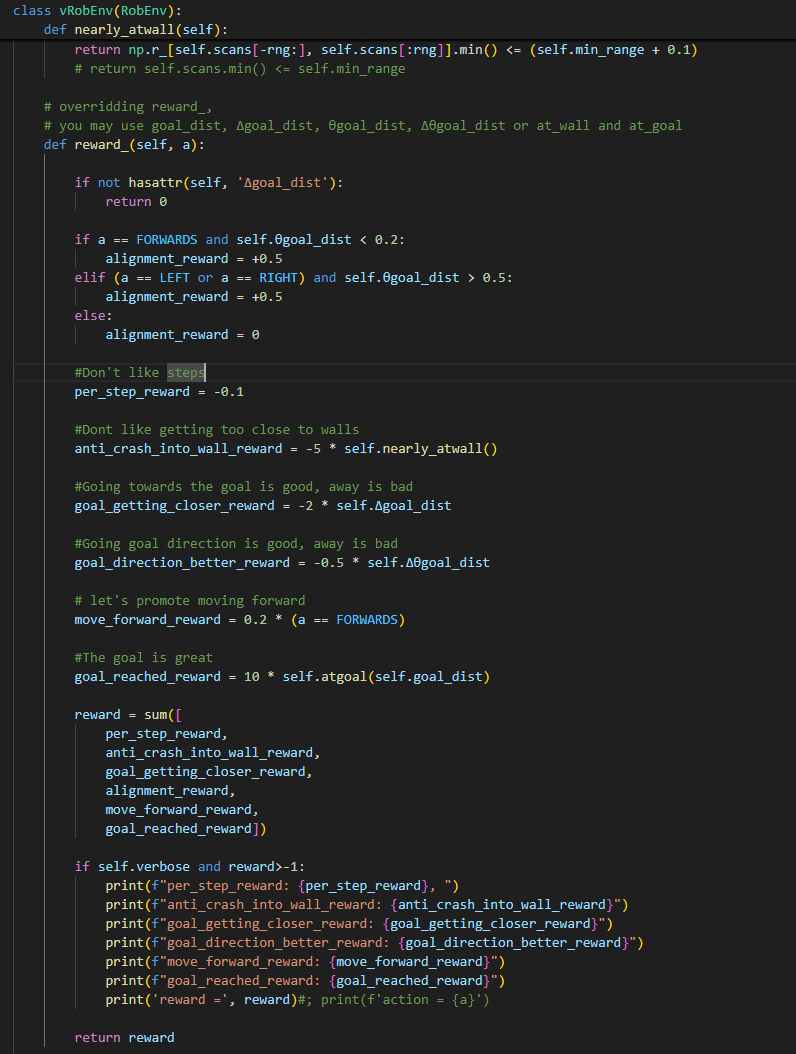

I added the "promote" moving forwards because it was getting stuck going around in circles. Given more time I'd start very simply and build up the rewards.

## Hyperparameter tuning

With Sarsaλ the optimum 


```plaintext
for ε in [0.1,0.2,0.5]:
    for λ in [0.1,0.3,0.5,0.8,1.1]:
        for γ in [0.1,0.5,0.99]:
```

With Sarsaλ the λ changes the algorith from TD(0) to MC on a sliding scale, and different ε will be best for these different approaches. I tried a grid search of solutions, however it wasn't until quite late that I learnt how to speed up the simulation. 

In [ ]:

for ε in [0.1,0.2,0.5]:
    for λ in [0.1,0.3,0.5,0.8,1.1]:
        for γ in [0.1,0.5,0.99]:

            max_t = 10
            εmin = 0.05
            dε = (ε - εmin) / max_t
        
            hyperparameters = {
                'max_t':max_t,
                'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
                'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
                'dε': dε, # dtop in epsilon per step
                'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
                'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
                'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step
            
                'verbose': False,
                
                # Robot Environment params
                'θspeed': pi / 2, 
                'speed': 3.0,        
                'n': 3    
            }
            print(hyperparameters)
            
            env = vRobEnvCornerDetector(
                speed=hyperparameters['speed'],
                θspeed=hyperparameters['θspeed'],
                n=hyperparameters['n'],
                verbose=hyperparameters['verbose']
            )
            
            vqlearn = Sarsaλ(
                env=env,
                α=hyperparameters['α'],          
                γ=hyperparameters['γ'],          
                λ=hyperparameters['λ'],           
                ε=hyperparameters['ε'],            
                εmin=hyperparameters['εmin'],        
                dε=hyperparameters['dε'],        
                q0=0,             
                Tstar=0,          
                max_t=hyperparameters['max_t'],       
                episodes=5,     
                self_path='SarsaLambda.vRobEnvCornerDetector.test012.pkl',
                seed=1,
                plotT=True, 
                plotR=True,
                visual=True, 
                animate=False
            )
            
            vqlearn.interact(resume=False, save_ep=True, plot_exp = True)

## Learning plots + success rates

### Q-Learning
![QLearn 001](LearningCurves/QLearn%20001.png)
![QLearn 002](LearningCurves/QLearn%20002.png)

### SARSA
![60 basic Sarsa](LearningCurves/60%20basic%20Sarsa.png)
![60 basic Sarsa2](LearningCurves/60%20basic%20Sarsa2.png)
![360 basic Sarsa3](LearningCurves/360%20basic%20Sarsa3.png)
![100 steps not enough](LearningCurves/100%20steps%20not%20enough.png)

### SARSA Changing Epsilon-Greedy
![Sarsa with 20Percent egreedy](LearningCurves/Sarsa%20with%2020Percent%20egreedy.png)
![Sarsa with 50Percent egreedy](LearningCurves/Sarsa%20with%2050Percent%20egreedy.png)

### SARSA(λ)
![SarsaLambda005](LearningCurves/SarsaLambda005.png)
![SarsaLambda006](LearningCurves/SarsaLambda006.png)
![SarsaLambda006 after 103 mins](LearningCurves/SarsaLambda006%20after%20103%20mins.png)
![SarsaLambda007](LearningCurves/SarsaLambda007.png)


In [4]:
max_t = 2000
ε = 0.2
εmin = 0.05
dε = (ε - εmin) / max_t

hyperparameters = {
    'max_t':max_t,
    'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
    'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
    'dε': dε, # dtop in epsilon per step
    'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
    'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         

    'verbose': False,
    
    # Robot Environment params
    'θspeed': pi / 2, 
    'speed': 3.0,        
    'n': 3    
}

env = vRobEnv(
    speed=hyperparameters['speed'],
    θspeed=hyperparameters['θspeed'],
    n=hyperparameters['n'],
    verbose=hyperparameters['verbose']
)

vqlearn = Qlearn(
    env=env,
    α=hyperparameters['α'],          
    γ=hyperparameters['γ'],                   
    ε=hyperparameters['ε'],            
    εmin=hyperparameters['εmin'],        
    dε=hyperparameters['dε'],        
    q0=0,             
    Tstar=0,          
    max_t=1200,       
    episodes=200,     
    self_path='Qlearn.test54.pkl',
    seed=1,
    **demoGame()
)

print(hyperparameters)
%time vqlearn.interact(resume=False, save_ep=True)

Reset not completed within timeout.
speed  =  3.0
θspeed =  1.57
state size(laser beams)= 64
{'max_t': 2000, 'ε': 0.2, 'εmin': 0.05, 'dε': 7.500000000000001e-05, 'α': 0.05, 'γ': 0.99, 'verbose': False, 'θspeed': 1.5707963267948966, 'speed': 3.0, 'n': 3}


IndexError: index 54 is out of bounds for axis 1 with size 3

CPU times: user 20min 42s, sys: 6min 23s, total: 27min 6s
Wall time: 8h 15min 16s


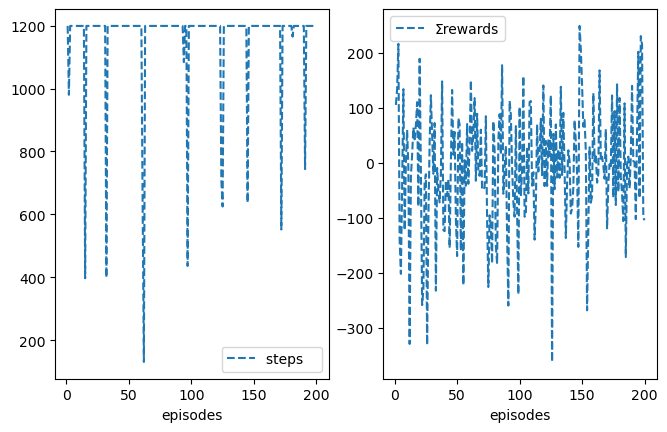

In [12]:
max_t = 2000
ε = 0.2
εmin = 0.05
dε = (ε - εmin) / max_t

hyperparameters = {
    'max_t':max_t,
    'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
    'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
    'dε': dε, # dtop in epsilon per step
    'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
    'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
    'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step

    'verbose': False,
    
    # Robot Environment params
    'θspeed': pi / 2, 
    'speed': 3.0,        
    'n': 3    
}

env = vRobEnv(
    speed=hyperparameters['speed'],
    θspeed=hyperparameters['θspeed'],
    n=hyperparameters['n'],
    verbose=hyperparameters['verbose']
)

vqlearn = Sarsaλ(
    env=env,
    α=hyperparameters['α'],          
    γ=hyperparameters['γ'],          
    λ=hyperparameters['λ'],           
    ε=hyperparameters['ε'],            
    εmin=hyperparameters['εmin'],        
    dε=hyperparameters['dε'],        
    q0=0,             
    Tstar=0,          
    max_t=1200,       
    episodes=200,     
    self_path='SarsaLambda.three_levels.test009.pkl',
    seed=1,
    **demoGame()
)

print(hyperparameters)
%time vqlearn.interact(resume=False, save_ep=True)

In [ ]:
max_t = 2000
ε = 0.2
εmin = 0.05
dε = (ε - εmin) / max_t

hyperparameters = {
    'max_t':max_t,
    'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
    'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
    'dε': dε, # dtop in epsilon per step
    'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
    'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
    'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step

    'verbose': False,
    
    # Robot Environment params
    'θspeed': pi / 2, 
    'speed': 3.0,        
    'n': 3    
}

env = vRobEnvCornerDetector(
    speed=hyperparameters['speed'],
    θspeed=hyperparameters['θspeed'],
    n=hyperparameters['n'],
    verbose=hyperparameters['verbose']
)

vqlearn = Sarsaλ(
    env=env,
    α=hyperparameters['α'],          
    γ=hyperparameters['γ'],          
    λ=hyperparameters['λ'],           
    ε=hyperparameters['ε'],            
    εmin=hyperparameters['εmin'],        
    dε=hyperparameters['dε'],        
    q0=0,             
    Tstar=0,          
    max_t=1200,       
    episodes=200,     
    self_path='SarsaLambda.three_levels.test009.pkl',
    seed=1,
    **demoGame()
)

print(hyperparameters)
vqlearn.interact(resume=False, save_ep=True)

In [ ]:
resume = False

if resume:
    vqlearn = Qlearn.selfload(self_path='vQlearn_exp')
    vqlearn.env = venv
    vqlearn.episodes = 105 # extend sthe number of episodes

# saving the object after each episode for retrieval in case of a crash 
%time vqlearn.interact(resume=resume, save_ep=True) 

reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (

KeyboardInterrupt: 

## Analysis of the results

The robot could reach goals but I couldn't get a policy which improved over time (it would not converge). I don't know if this is because of my reward, hyperparameters, or the state representation. The "solution space" is very big, and I'd like to seek guidance from people with experience as to what type of state representation and rewards should work at all - at least nudge me into the correct area. Speeding up the simulation was very useful.  



# Model 2: Either policy gradient or value-based with non-linear function approximation

## RL method explanation + justification

The non linear agents are definied in rlnn.py DQN was picked, this is an action value based learning algorithm, where the agent learns to estimate the expected return (Q-value) for each possible action, and selects the action with the highest Q-value. It's suited for Non Linear control where the laser scan inputs can be passed into the NN directly, and it can learn to pull "features" out of the high dimensional laser scan data and then associate those features (say near a wall, or something curved and round ahead) to a value.

If I had more time I'd like to extend it to try and be policy based approach (this video by David Silver is really good: RL Course by David Silver - Lecture 7: Policy Gradient Methods) learning a stochastic policy might be good, because there are two goals and you want to choose randomly between them.

## State representation

Previously for the linear model we had to use something which could be combinded "linearly" to create the value function approximation. 

For the NN we can use the lasers without having to descritise them. I normalise them to 0 and 1 - this is generally a good idea for inputs into a NN.

```plaintext
def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

```

## Reward function

The reward function design was the same as for the Linear Model.

## Hyperparameter tuning

The main parameters I changes were the h1 and h2 starting small (way to small) and increasing the size, the idea being that the NN would be able to learn the features and map them to a value. However, I think my reward wasn't working well enough, so all these were basically complete failures. Eventually I went up to 256 and also changed the reward to the one provided in the lecture note examples. However the robot would basically spin in a circle.

- `t_Qn`: Frequency (in steps) of updating the target network, used to stabilize learning alongside the main network.
- `save_weights`: Determines how often the model's weights are saved to disk, which is useful for resuming training after interruptions.
- `nbatch`: Size of the *mini-batch* sampled from the experience replay buffer for training.
- `nbuffer`: Minimum number of experiences required in the *replay buffer* before learning commences.
- `h1`: Size of the first hidden layer (set to `0` for no hidden layer).
- `h2`: Size of the second hidden layer (also settable to `0` if not needed).

## Learning plots + success rates

See below, there's very little success. Most maxed out to the max episodes.

CPU times: user 41min 34s, sys: 5min 16s, total: 46min 50s
Wall time: 1h 2min


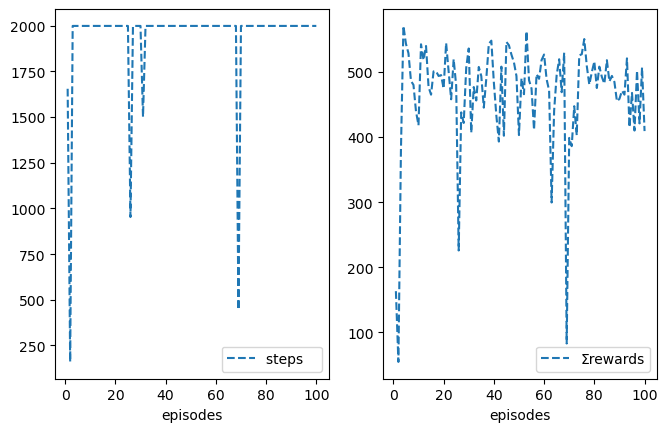

In [ ]:



class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.nF = len(self.scans)
        
    def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

env = nnRobEnv()

class cudaDQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw):
        print('--------------------- 易  cudaDQN is being set up 易 -----------------------')
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    def greedy(self, s):
        self.isamax = True
        Qs = self.Q_(s)
        Qs_np = Qs.detach().cpu().numpy() #WE NEED TO BRING THE DATA BACK FROM THE GPU for NUMPy
        from numpy.random import choice
        return choice((Qs_np == Qs_np.max()).nonzero()[0])

    def online(self, *args):
        if len(self.buffer) < self.nbatch:
            return

        (s, a, rn, sn, dones), inds = self.batch()

        Qs = self.qN(s)
        Qn = self.qNn(sn).detach()
        Qn[dones] = 0

        target = Qs.clone().detach()
        target[inds, a] = self.γ * Qn.max(1).values + rn.to(self.device)
        loss = self.qN.fit(Qs, target)

        if self.t_ % self.t_Qn == 0:
            self.qNn.set_weights('Q', self.t_)
            print(f'loss = {loss}')


nnqlearn = cudaDQN(
    env=env, 
    episodes=100, 
    α=1e-4,
    ε=0.5, 
    dε=.99, 
    εmin=0.01, 
    γ=.95, 
    h1=3, 
    h2=3, 
    nF=env.nF,
    nbuffer=5000, 
    nbatch=32, 
    endbatch=8,
    t_Qn=100, 
    self_path='DQN_exp.pkl',
    seed=1, 
    **demoGame())

for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


%time nnqlearn.interact(resume=False, save_ep=True) 

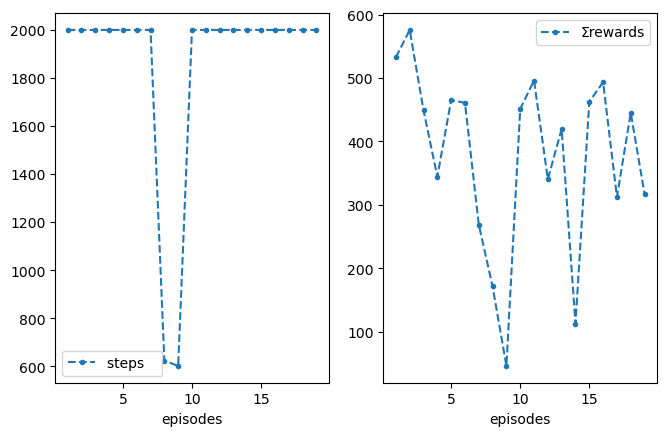

could not save the file {self.self_path}


/home/danb/git/turtlebot-as2/rl/rlnn.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s,    dtype=torch.float32),
/home/danb/git/turtlebot-as2/rl/rlnn.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sn,   dtype=torch.float32),


update Q network weights...........! at 35400
loss = 0.014120114967226982
update Q network weights...........! at 35700
loss = 0.026033079251646996


RuntimeError: Unable to convert call argument to Python object (compile in debug mode for details)

In [5]:
class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.nF = len(self.scans)
        
    def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

env = nnRobEnv()

class cudaDQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw):
        print('--------------------- 易  cudaDQN is being set up 易 -----------------------')
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    def greedy(self, s):
        self.isamax = True
        Qs = self.Q_(s)
        Qs_np = Qs.detach().cpu().numpy() #WE NEED TO BRING THE DATA BACK FROM THE GPU for NUMPy
        from numpy.random import choice
        return choice((Qs_np == Qs_np.max()).nonzero()[0])

    def online(self, *args):
        if len(self.buffer) < self.nbatch:
            return

        (s, a, rn, sn, dones), inds = self.batch()

        Qs = self.qN(s)
        Qn = self.qNn(sn).detach()
        Qn[dones] = 0

        target = Qs.clone().detach()
        target[inds, a] = self.γ * Qn.max(1).values + rn.to(self.device)
        loss = self.qN.fit(Qs, target)

        if self.t_ % self.t_Qn == 0:
            self.qNn.set_weights('Q', self.t_)
            print(f'loss = {loss}')


#increase training time, 
nnqlearn = cudaDQN(
    env=env, 
    episodes=300,       
    α=5e-4,
    ε=0.9, 
    dε=0.995, 
    εmin=0.05, 
    γ=0.99, 
    h1=64, 
    h2=64, 
    nF=env.nF,
    nbuffer=10000, 
    nbatch=32, 
    endbatch=8,
    t_Qn=300, 
    self_path='DQN_exp.pkl',
    seed=1, 
    **demoGame())

for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


%time nnqlearn.interact(resume=False, save_ep=True) 

In [7]:
class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.nF = len(self.scans)
    
    def reward_(self, a):
        # s_type 0-reached a goal, 1-hits a wall 2-moved forward or 3-turn
        s_type = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)

        # identify the nearest goal and obtain the distance and the angular distance to it 
        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        #  reward/penalise robot relative to its orientation towards a goal
        θdist = round(abs(abs(self.θ - θgoal) - pi*goal), 2) # subtract pi if it's goal 1 (behind)

        reward = self.rewards[s_type]
        reward = self.reward(reward, dist, θdist, s_type)
        
        return reward

    def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

env = nnRobEnv()

class cudaDQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw):
        print('--------------------- 易  cudaDQN is being set up 易 -----------------------')
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    def greedy(self, s):
        self.isamax = True
        Qs = self.Q_(s)
        Qs_np = Qs.detach().cpu().numpy() #WE NEED TO BRING THE DATA BACK FROM THE GPU for NUMPy
        from numpy.random import choice
        return choice((Qs_np == Qs_np.max()).nonzero()[0])

    def online(self, *args):
        if len(self.buffer) < self.nbatch:
            return

        (s, a, rn, sn, dones), inds = self.batch()

        Qs = self.qN(s)
        Qn = self.qNn(sn).detach()
        Qn[dones] = 0

        target = Qs.clone().detach()
        target[inds, a] = self.γ * Qn.max(1).values + rn.to(self.device)
        loss = self.qN.fit(Qs, target)

        if self.t_ % self.t_Qn == 0:
            self.qNn.set_weights('Q', self.t_)
            print(f'loss = {loss}')


#increase training time, 
nnqlearn = cudaDQN(
    env=env, 
    episodes=300,       
    α=5e-4,
    ε=0.9, 
    dε=0.995, 
    εmin=0.05, 
    γ=0.99, 
    h1=256, 
    h2=256, 
    nF=env.nF,
    nbuffer=10000, 
    nbatch=32, 
    endbatch=8,
    t_Qn=300, 
    self_path='DQN_exp2.pkl',
    seed=1, 
    **demoGame())

for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


%time nnqlearn.interact(resume=False, save_ep=True) 

[WARN] [1745829328.396560857] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


speed  =  2.0
θspeed =  1.57
state size(laser beams)= 64
--------------------- 易  cudaDQN is being set up 易 -----------------------
Model on device:cuda
╭─────────────────────────────────────────────────────────────╮
│               Model Architecture for Q net                  │
├────┬────────────────────────────┬────────────┬──────────────┤
│ Id │ Layer                      │ Parameters │ Trainable    │
├────┼────────────────────────────┼────────────┼──────────────┤
│  0 │ layers.0.weight            │     16,384 │ Yes          │
│  1 │ layers.0.bias              │        256 │ Yes          │
│  2 │ layers.1.weight            │     65,536 │ Yes          │
│  3 │ layers.1.bias              │        256 │ Yes          │
│  4 │ layers.2.weight            │     16,384 │ Yes          │
│  5 │ layers.2.bias              │         64 │ Yes          │
│  6 │ layers.3.weight            │        192 │ Yes          │
│  7 │ layers.3.bias              │          3 │ Yes          │
├────┴─────────

TypeError: RobEnv.atgoal() missing 1 required positional argument: 'goal_dist'

In [8]:
#accelerate_sim(speed=100)
set_nscans_LiDAR(nscans=360)

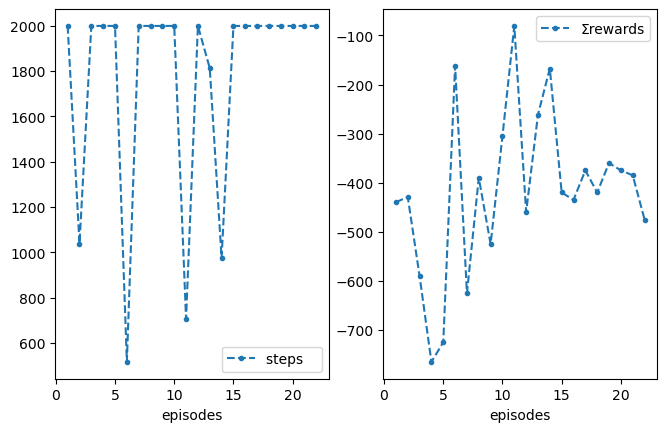

could not save the file {self.self_path}


/home/danb/git/turtlebot-as2/rl/rlnn.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s,    dtype=torch.float32),
/home/danb/git/turtlebot-as2/rl/rlnn.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(sn,   dtype=torch.float32),


update Q network weights...........! at 39300
loss = 0.0035610822960734367
update Q network weights...........! at 39600
loss = 0.004673745948821306
update Q network weights...........! at 39900
loss = 0.014230512082576752
update Q network weights...........! at 40200
loss = 0.2563660740852356
update Q network weights...........! at 40500
loss = 0.06051730364561081
update Q network weights...........! at 40800
loss = 0.26349371671676636


KeyboardInterrupt: 

In [9]:
class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.nF = len(self.scans)
        
    def reward_(self, a):

        if not hasattr(self, 'Δgoal_dist'):
            return 0

        #Don't like steps
        per_step_reward = -0.1 

        #Dont like getting too close to walls 
        anti_crash_into_wall_reward = -5 * self.nearly_atwall() 

        #The goal is great
        goal_reached_reward = 10 * self.atgoal(self.goal_dist)

        reward = sum([
            per_step_reward, 
            anti_crash_into_wall_reward,
            goal_reached_reward])
        
        if self.verbose and reward>-1:
            print(f"per_step_reward: {per_step_reward}, ")
            print(f"anti_crash_into_wall_reward: {anti_crash_into_wall_reward}")
            print(f"goal_reached_reward: {goal_reached_reward}")
            print('reward =', reward)#; print(f'action = {a}')
        
        return reward


    def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

env = nnRobEnv()

class cudaDQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw):
        print('--------------------- 易  cudaDQN is being set up 易 -----------------------')
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    def greedy(self, s):
        self.isamax = True
        Qs = self.Q_(s)
        Qs_np = Qs.detach().cpu().numpy() #WE NEED TO BRING THE DATA BACK FROM THE GPU for NUMPy
        from numpy.random import choice
        return choice((Qs_np == Qs_np.max()).nonzero()[0])

    def online(self, *args):
        if len(self.buffer) < self.nbatch:
            return

        (s, a, rn, sn, dones), inds = self.batch()

        Qs = self.qN(s)
        Qn = self.qNn(sn).detach()
        Qn[dones] = 0

        target = Qs.clone().detach()
        target[inds, a] = self.γ * Qn.max(1).values + rn.to(self.device)
        loss = self.qN.fit(Qs, target)

        if self.t_ % self.t_Qn == 0:
            self.qNn.set_weights('Q', self.t_)
            print(f'loss = {loss}')


#increase training time, 
nnqlearn = cudaDQN(
    env=env, 
    episodes=300,       
    α=5e-4,
    ε=0.9, 
    dε=0.995, 
    εmin=0.05, 
    γ=0.99, 
    h1=64, 
    h2=64, 
    nF=env.nF,
    nbuffer=10000, 
    nbatch=32, 
    endbatch=8,
    t_Qn=300, 
    self_path='DQN_exp.pkl',
    seed=1, 
    **demoGame())

for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


%time nnqlearn.interact(resume=False, save_ep=True) 

## Analysis of the results

I got this working on my local GPU which was good, I learn't a lot about the .to device and tensors.

However, with regard to the actual learn't policy, not very good at all. I really do think it's my reward function, I need to investigate more.

# Conclusion and Reflection on what went wrong and what worked well

I've learnt a lot about the messy world of robotics, and it is very frustrating. I think if this was a paired team project I might have performed better. My challenges were 

- It took a while to understand ROS, its components and how they interacted. 
- I wanted to run this on my own machine, this took a long time to work out, but I'm pleased I did.
- Understanding the RL models (linear vs non-linear) code - I really had to explore and understand the structure, once I spent time on the code base then it clicked, but it took a while.
- I'm still very unsure about how to design the rewards properly I highly suspect this contributed to the bad policy improvement.
- I'm not sure about the state representation, I think this is a wide area, there's so many different ways to approach this I wasn't sure.
- Hyperparameter tuning took so long because the solution space is massive.
- I left it too late and ran out of time, I could have done with another couple of days (my fault)

Positives

I've learnt a lot about the application of the theory. I'd keen to try and spend more time on this type of project.


# References

- RL Course by David Silver - Lecture 7: Policy Gradient Methods - reinforcement learning. YouTube video, Available at: https://www.youtube.com/watch?v=KHZVXao4qXs [Accessed 28 April 2025].

- Núñez, P., Vazquez-Martin, R., Bandera, A., and Romero-Gonzalez, C. (2015) ‘Feature extraction from laser scan data based on curvature estimation for mobile robotics’, *Robotics and Autonomous Systems*, 70, pp. 103–114. Available at: [https://robolab.unex.es/wp-content/papercite-data/pdf/feature-extraction-from-laser.pdf](https://robolab.unex.es/wp-content/publicaciones/2006/Nunez%20Trujillo,%20Vazquez-Martin,%20del%20Toro,%20Bandera%20%7C%20Feature%20extraction%20from%20laser%20scan%20data%20based%20on%20curvature%20estimation%20for%20mobile%20robotics.pdf) (Accessed: 26 April 2025).

- Ramos, J., Rocha, R., and Dias, J. (2022) ‘Efficient approach for extracting high-level B-spline features from laser scan data’, *Sensors*, 22(24), 9737. Available at: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/) (Accessed: 26 April 2025).

- Shen, S., Michael, N., and Kumar, V. (2012) ‘Method for corner feature extraction from laser scan data’, *ResearchGate*. Available at: [https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data](https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data) (Accessed: 26 April 2025).

- Stack Overflow (2019) ‘How can I detect the corner from 2D point cloud or LiDAR scanned data?’, *Stack Overflow*. Available at: [https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data](https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data) (Accessed: 26 April 2025).


- CETI. (n.d.) *Simulation Speed in ROS/Gazebo*. Available at: [https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html](https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html) (Accessed: 26 April 2025).

- Furrer, F., Wermelinger, M., Naegeli, T., et al. (2021) ‘Dynamics and Control of Quadrotor UAVs: A Survey’, *IEEE Transactions on Robotics*, 37(5), pp. 1381–1400. Available at: [https://ieeexplore.ieee.org/document/9453594](https://ieeexplore.ieee.org/document/9453594) (Accessed: 26 April 2025).

- Perez-Perez, J., Jimenez, F. and Mata, M. (2023) ‘An Overview of Reinforcement Learning in Autonomous Driving: Fundamentals, Challenges, and Applications’, *Applied Sciences*, 13(12), p. 7202. Available at: [https://www.mdpi.com/2076-3417/13/12/7202](https://www.mdpi.com/2076-3417/13/12/7202) (Accessed: 26 April 2025).


# Appendicies

## Cool links / interesting reading: 
- https://github.com/hello-robot/stretch_ros/blob/master/stretch_funmap/README.md
- https://arxiv.org/pdf/2502.20607

## Miscelaneous Notes

### Setting up ROS
- https://emanual.robotis.com/docs/en/platform/turtlebot3/sbc_setup/
- https://ros2-industrial-workshop.readthedocs.io/en/latest/_source/navigation/ROS2-Turtlebot.html
- https://emanual.robotis.com/docs/en/platform/turtlebot3/navigation/
- https://emanual.robotis.com/docs/en/platform/turtlebot3/bringup/#bringup

### Multicast traffic (for DDS) through Windows FW to WSL2:
- https://eprosima-dds-router.readthedocs.io/en/latest/rst/examples/repeater_example.html#execute-example
- New-NetFirewallRule -Name 'WSL' -DisplayName 'WSL' -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -Direction Inbound -Action Allow
- New-NetIPAddress -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -IPAddress '192.168.1.217' -PrefixLength 24
- https://github.com/DanielBryars/multicast-test.git

### VM
- https://labs.azure.com/virtualmachines?feature_vnext=true

## Framework modifications

### Ignore Reset parameter

Modified RobEnv so that I can run it in "passive" mode for monitoring what the state of the robot and rewards are doing in realtime

```plaintext
self.ignoreReset

self.reset_world = self.create_client(Empty, '/reset_world')
        if (ignoreReset):
            print("ignoreReset is True Skipping world reset")
        else:
            while not self.reset_world.wait_for_service(timeout_sec=4.0):
                print('world client service...')

def reset(self):
        '''Override the original so we can skip the reset (used for monitoring applications)'''
        if (self.ignoreReset):
            print("Reset called BUT self.ignoreReset is True, so ignoring")
            return self.s_()
        else:
            return super().reset()
```

### modify to save a picture and a json file of the parameters work in progress.

```plaintext
def plot_ep(self, animate=None, plot_exp=False, label='', savefig=False): 
        if len(self.eplist)< self.episodes: self.eplist.append(self.ep+1)
            
        if animate is None: animate = self.animate
        if not animate: return
        frmt='.--'if not plot_exp or self.ep==0 else '--'

        if self.visual: 
            if self.ep==self.episodes-1: self.render(animate=False) # shows the policy 
            else:                        self.env.render(animate=False) 
        if self.plotV:  self.plot_V(ep=self.ep+1)        
        
        i=2
        for plot, ydata, label_ in zip([self.plotT, self.plotR, self.plotE], 
                                      [self.Ts,    self.Rs,    self.Es   ], 
                                      ['steps   ', 'Σrewards', 'Error   ']):
            if not plot: continue
            plt.subplot(1,3,min(i,3)).plot(self.eplist[:self.ep+1], ydata[:self.ep+1], frmt, label=label_+label)
            plt.xlabel('episodes')
            plt.legend()
            i+=1
        
        # if there is any visualisation required then we need to care for special cases    
        if self.plotV or self.plotE or self.plotT or self.plotR:
            figsizes = list(zip(plt.gcf().get_size_inches(), self.env.figsize0))
            figsize  = [max(figsizes[0]), min(figsizes[1]) if self.plotV or self.plotE else figsizes[1][0]]
            plt.gcf().set_size_inches(figsize[0], figsize[1])
            clear_output(wait=True)
            if not plot_exp:
                plt.show()
            else:
                if savefig:
                    descriptive_name = f'{self.desctime}.{self.__class__.__name__}.episode.{self.ep}'
                    safe_params = self.make_json_safe(self.params)             
                    with open(f'{descriptive_name}.json', 'w') as f:
                        json.dump(safe_params, f, indent=2)
                    plt.savefig(f'{descriptive_name}.png')
```

There were a couple of bugs which I fixed

### Cuda/Device movements in the nn stuff

### Race for state not seen
```plaintext
'''
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File <timed eval>:1

File ~/git/turtlebot-as2/rl/rl.py:192, in MRP.interact(self, train, resume, save_ep, episodes, grid_img, **kw)
    189 self.t += 1
    190 self.t_+= 1
--> 192 rn,sn, a,an, done = self.step(s,a, self.t)  # takes a step in env and store tarjectory if needed
    193 self.online(s, rn,sn, done, a,an) if train else None # to learn online, pass a one step trajectory
    195 self.Σr += rn

File ~/git/turtlebot-as2/rl/rl.py:153, in MRP.step_an(self, s, a, t)
    151 if self.skipstep: return 0, None, None, None, True
    152 sn, rn, done, _ = self.env.step(a)
--> 153 an = self.policy(sn)
    155 # we added s=s for compatibility with deep learning later
    156 self.store_(s=s, a=a, rn=rn, sn=sn, an=an, done=done, t=t)

File ~/git/turtlebot-as2/rl/rl.py:487, in MDP.<locals>.MDP.εgreedy(self, s)
    484 if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
    485 if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
--> 487 return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)

File ~/git/turtlebot-as2/rl/rl.py:477, in MDP.<locals>.MDP.greedy(self, s)
    474 # print(s)
    475 # print(Qs)
    476 if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')
--> 477 return choices(np.where(Qs==Qs.max())[0])[0]

File /usr/lib/python3.10/random.py:519, in Random.choices(self, population, weights, cum_weights, k)
    517     floor = _floor
    518     n += 0.0    # convert to float for a small speed improvement
--> 519     return [population[floor(random() * n)] for i in _repeat(None, k)]
    520 try:
    521     cum_weights = list(_accumulate(weights))

File /usr/lib/python3.10/random.py:519, in <listcomp>(.0)
    517     floor = _floor
    518     n += 0.0    # convert to float for a small speed improvement
--> 519     return [population[floor(random() * n)] for i in _repeat(None, k)]
    520 try:
    521     cum_weights = list(_accumulate(weights))

IndexError: index 0 is out of bounds for axis 0 with size 0

FIXED BY EDITING rl.py

#------------------------------------- add some more policies types 易-------------------------------
        # useful for inheritance, gives us a vector of actions values
        def Q_(self, s=None, a=None):

            #Originally return self.Q[s] if s is not None else self.Q

            if s is None:
                return self.Q  
            
            #just initialise to 0 for now, not sure how to handle this.
            if s not in self.Q:
                self.Q[s] = np.zeros(self.env.nA) 
            
            return self.Q[s]

'''
```

### S_ instead of s_ in rl.py
```plaintext
--------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <timed eval>:1

File ~/git/turtlebot-as2/rl/rl.py:182, in MRP.interact(self, train, resume, save_ep, episodes, grid_img, **kw)
    179 done = False
    180 #print(self.ep)
    181 # initial step
--> 182 s,a = self.step_0()
    183 self.step0()                                    # user defined init of each episode
    184 # an episode is a set of steps, interact and learn from experience, online or offline.

File ~/git/turtlebot-as2/rl/rl.py:134, in MRP.step_0(self)
    132 def step_0(self):
    133     s = self.env.reset()                                 # set env/agent to the start position
--> 134     a = self.policy(s)
    135     return s,a

File ~/git/turtlebot-as2/rl/rl.py:499, in MDP.<locals>.MDP.εgreedy(self, s)
    496 if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
    497 if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
--> 499 return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)

File ~/git/turtlebot-as2/rl/rl.py:485, in MDP.<locals>.MDP.greedy(self, s)
    483 self.isamax = True
    484 # instead of returning np.argmax(Q[s]) get all max actions and return one of the max actions randomly
--> 485 Qs = self.Q_(s)
    486 # print(s)
    487 # print(Qs)
    488 if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')

File ~/git/turtlebot-as2/rl/rlln.py:149, in vMDP.Q_(self, s, a)
    145 def Q_(self, s=None, a=None):
    146     #print(f"{s.shape}, {a}")
    148     W = self.W if a is None else self.W[a]
--> 149     return W.dot(s) if s is not None else np.matmul(W, self.env.S_()).T

AttributeError: 'vRobEnv' object has no attribute 'S_'
```